# A Tutorial on Sparsity via Regularisation 

This file is created as a trial of sparsity on a regression example. We consider a dataset with p features and n sample. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

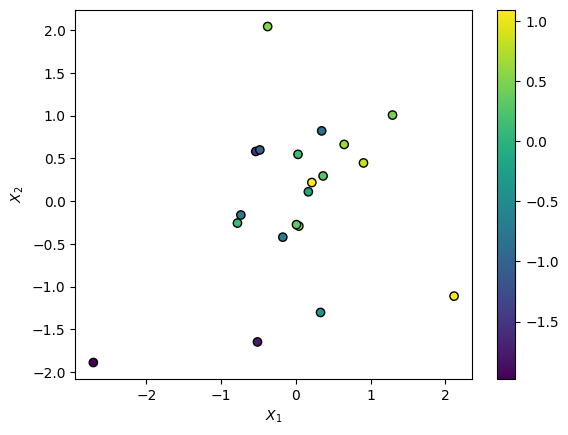

In [2]:
RNG = np.random.default_rng(seed=1)
p = 2
n = 20
var = 1
cov = var*np.eye(p)
mean = np.zeros(p)
sigma = 1

# To define the weights as beta
beta = np.array([1, 0]) 

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

# To show the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.colorbar()
plt.show()

The loss function also is defined as a squared norm of residuals as follows <br>
$Loss\;Function=\vert\vert X\beta - Y\vert\vert_2^2$

In [3]:
# To define the loss function
# def squared_error(beta):
#     return np.linalg.norm(x.dot(np.atleast_2d(beta).T) - y.reshape(-1, 1), axis=0)**2

# To define another form of loss function
def squared_error(beta):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, 2))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

In [4]:
# To check the loss function
squared_error(beta)

array([10.26943722])

Then we define a space of 2 dimensions for all probable $\beta \in \mathcal{B}$ and calculate the loss function for this space. <br>
After that the residuals (errors) corresponding to the all beta estimation space and real output would be calculated.

In [5]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[0]
_beta2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta = np.reshape(_beta, (-1,2))
# _beta.shape

In [530]:
# To calculate the residuals between real output "y" and estimation space "x*_beta"
# error_space = squared_error(_beta)
# error_space

Now here we find the best estimated weights by least square optimization method.

In [6]:
# To define beta_hat by least square mathod
beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))
# least square in another calculation
# beta_hat = (np.linalg.inv(x.T@x)@x.T)@y
# beta_hat

Here we add a regularization (penalty/punishemnt) term to the loss function to sparse the solution space. It would be written as follows <br>
$Regularized\;Loss\;Function = \vert\vert X\beta - Y\vert\vert_2^2 + \alpha*\vert\vert \beta \vert\vert$ <br>
Actually, this penalty term sparses the solution space and we may restrict it by considering $\beta$ as a binary parameter. 

In [7]:
from numpy.linalg import norm

# alpha=100
# def regularised_error(beta):
#     return squared_error(beta) + alpha*norm(np.atleast_2d(beta), 1, axis=1)

# To define the regularized loss function
def regularised_error(beta,alpha):
    return squared_error(beta) + alpha*np.sum(abs(np.reshape(beta,(-1,2))),axis=1)

# squared_error(beta,alpha=1)
# regularised_error(beta,alpha=1)

# squared_error(_beta)
# regularised_error(_beta,1)

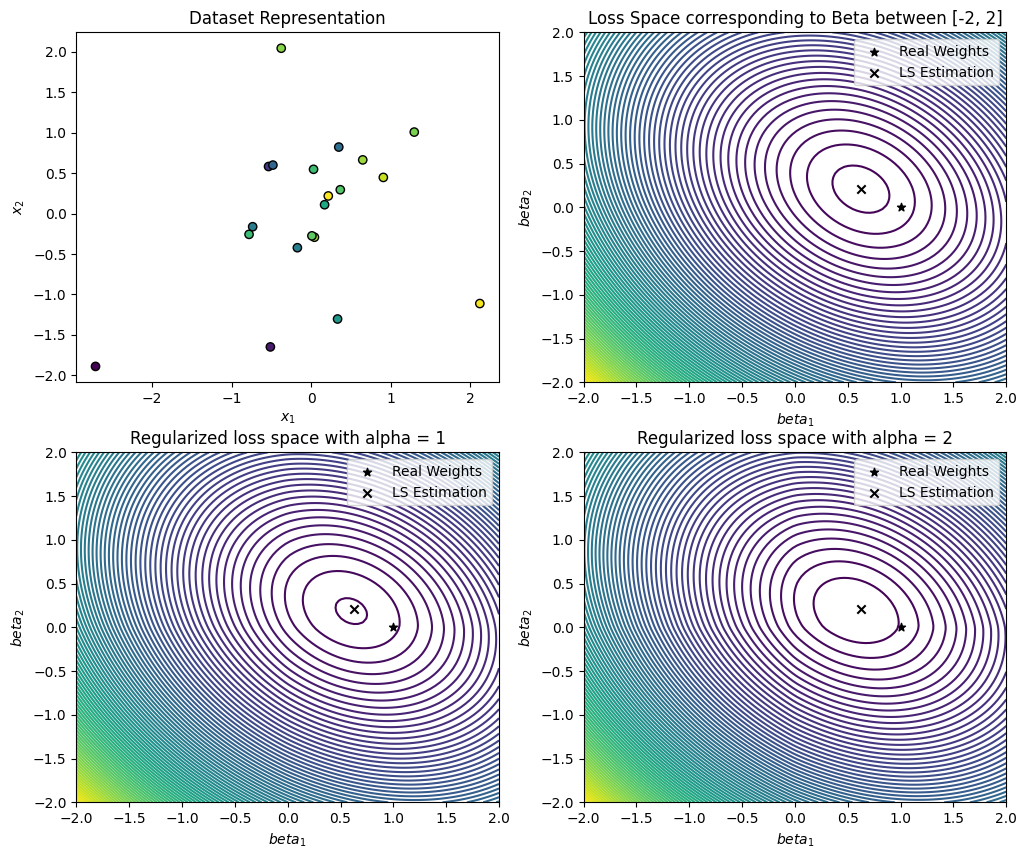

In [8]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0,0].scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
axs[0,0].set_xlabel('$x_1$')
axs[0,0].set_ylabel('$x_2$')
axs[0,0].title.set_text('Dataset Representation')


# axs[1].contourf(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), error_space.reshape(100, 100), levels=50, cmap='Reds')
axs[0,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), squared_error(_beta).reshape(100, 100), levels=100)
axs[0,1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[0,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0,1].set_xlabel('$beta_1$')
axs[0,1].set_ylabel('$beta_2$')
axs[0,1].legend()
axs[0,1].title.set_text('Loss Space corresponding to Beta between [-2, 2]')

axs[1,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=1).reshape(100, 100), levels=100)
axs[1,0].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,0].set_xlabel('$beta_1$')
axs[1,0].set_ylabel('$beta_2$')
axs[1,0].legend()
axs[1,0].title.set_text('Regularized loss space with alpha = 1')

axs[1,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=2).reshape(100, 100), levels=100)
axs[1,1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,1].set_xlabel('$beta_1$')
axs[1,1].set_ylabel('$beta_2$')
axs[1,1].legend()
axs[1,1].title.set_text('Regularized loss space with alpha = 2')

plt.show()

It should be noted that the final goal is to obtain $\beta$ which minimize the regularized loss function. <br>
$\hat{\beta} = \underset{\beta \in \mathcal{B}}{argmin} \; \vert\vert X\beta - Y\vert\vert_2^2 + \alpha*\vert\vert \beta \vert\vert $ <br>
Now we use SciPy to minimize the regularized (penalized) loss function. 

In [9]:
import scipy
from scipy.optimize import minimize
alpha=2
def minimizer(alpha):
    initial_beta = np.random.randint(p,size=(2))
    # scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')
    result = minimize(regularised_error, initial_beta, method='Nelder-Mead', args=(alpha))
    optimized_beta = result.x
    return optimized_beta


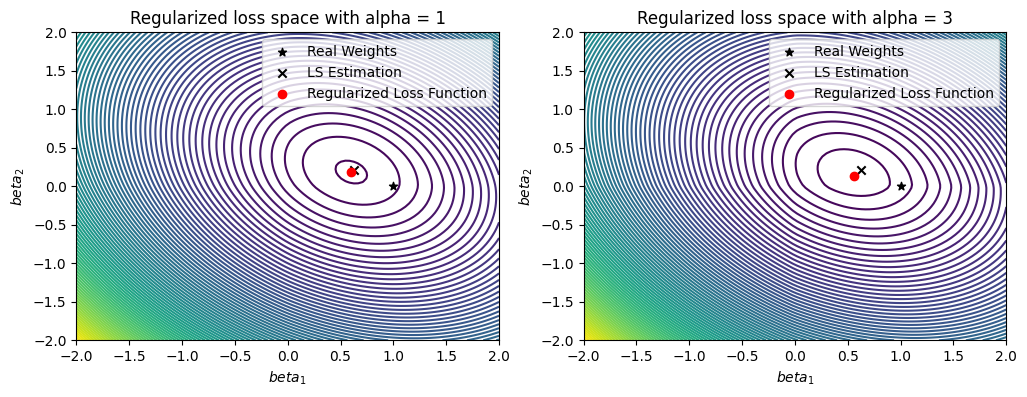

In [10]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=1).reshape(100, 100), levels=100)
axs[0].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0].scatter(minimizer(alpha=1)[0], minimizer(alpha=1)[1], marker='o', color='red', label='Regularized Loss Function')
axs[0].set_xlabel('$beta_1$')
axs[0].set_ylabel('$beta_2$')
axs[0].legend()
axs[0].title.set_text('Regularized loss space with alpha = 1')

axs[1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=3).reshape(100, 100), levels=100)
axs[1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1].scatter(minimizer(alpha=3)[0], minimizer(alpha=3)[1], marker='o', color='red', label='Regularized Loss Function')
axs[1].set_xlabel('$beta_1$')
axs[1].set_ylabel('$beta_2$')
axs[1].legend()
axs[1].title.set_text('Regularized loss space with alpha = 3')

plt.show()

We can write the loss function as <br>
$RLF = (X\beta-Y)^T(X\beta-Y) + \alpha \beta I_{p\times 1}$ <br>
RLF is a short form for regularized loss function. Then we consider the first derivative respect to $\beta$ <br>
$\frac{\partial RLF}{\partial \beta} = 2X^T(X\beta-Y)+\alpha I_{p\times 1}$ <br>
If we set it to zero then we obtain <br>
$\beta_{opt}=-\frac{1}{2}\alpha (X^TX)^{-1}I_{p\times 1}+(X^TX)^{-1}X^TY$ <br>


In [13]:
def opt_beta(alpha):
    alpha = 1
    I = np.array([1,1])
    beta_opt = -0.5*alpha*np.linalg.inv(x.T@x)@I+np.linalg.inv(x.T@x)@x.T@y
    return beta_opt

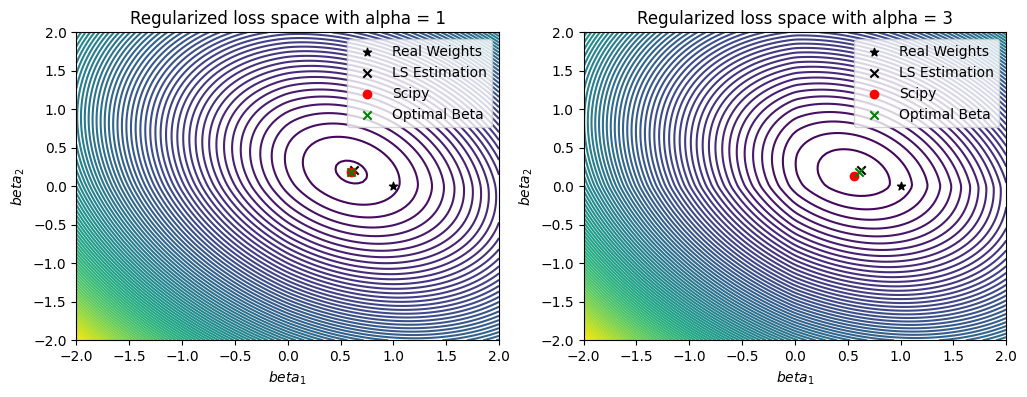

In [20]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=1).reshape(100, 100), levels=100)
axs[0].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0].scatter(minimizer(alpha=1)[0], minimizer(alpha=1)[1], marker='o', color='red', label='Scipy')
axs[0].scatter(opt_beta(alpha=1)[0], opt_beta(alpha=1)[1], marker='x', color='green', label='Optimal Beta')
axs[0].set_xlabel('$beta_1$')
axs[0].set_ylabel('$beta_2$')
axs[0].legend()
axs[0].title.set_text('Regularized loss space with alpha = 1')

axs[1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=3).reshape(100, 100), levels=100)
axs[1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1].scatter(minimizer(alpha=3)[0], minimizer(alpha=3)[1], marker='o', color='red', label='Scipy')
axs[1].scatter(opt_beta(alpha=3)[0], opt_beta(alpha=3)[1], marker='x', color='green', label='Optimal Beta')
axs[1].set_xlabel('$beta_1$')
axs[1].set_ylabel('$beta_2$')
axs[1].legend()
axs[1].title.set_text('Regularized loss space with alpha = 3')

plt.show()